In [ ]:
!pip install finance-datareader

In [ ]:
import pandas as pd
import requests
import re
import time
import random
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr 
from datetime import timedelta
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(<matplotlib.axes._subplots.AxesSubplot at 0x7faf9707e810>,
                     Sum  First_Balance  Sum_CAGR    Sum_MDD  Sharp_Ratio
 2021-12-30  1453.121026           1000  9.793201  13.678609     1.085304)

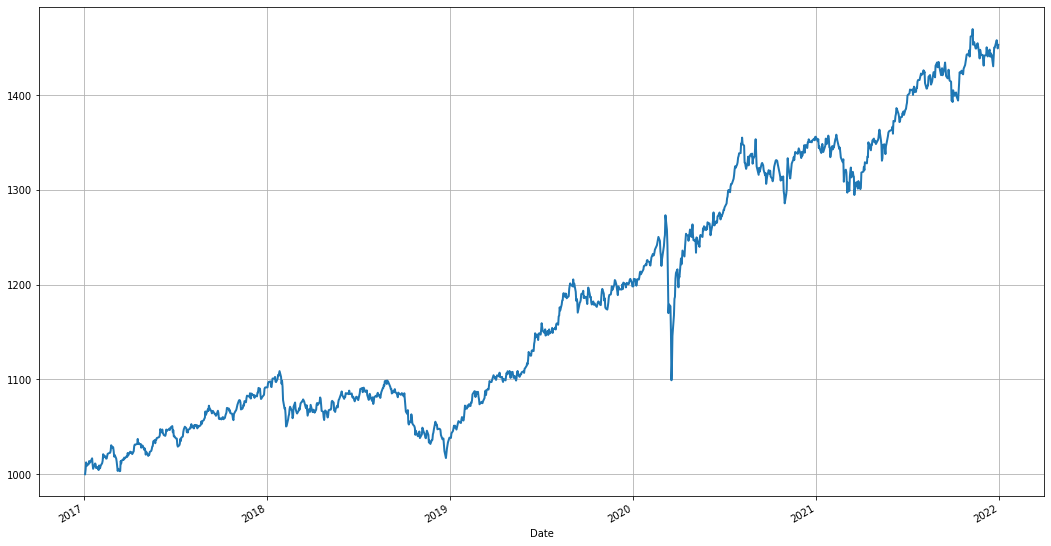

In [ ]:
# 차트설정
%matplotlib inline
plt.rc('font', family='NanumSquare')
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True


#### 개별 종목 함수 만들기
def single_result(first_balance, code, rate, buy_date, end_date):
    single_etf = pd.DataFrame(fdr.DataReader(code, buy_date, end_date)['Close'])

    ## 각 칼럼 생성
    single_etf['Rate'] = 0  # 첫 수익률은 0라 생각하고 시작
    single_etf[code] = first_balance * rate  # 첫 행의 보유 금액 = 처음 자산 * 자산배분비율

    #### 수익률, 평가금액 구하는 법
    for x in range(1, len(single_etf)):
        # 각 행의 수익률 = (현재 가격 - 이전 가격)/이전가격 * 100
        single_etf['Rate'].iloc[x] = ((single_etf['Close'].iloc[x] - single_etf['Close'].iloc[x - 1]) /
                                      single_etf['Close'].iloc[x - 1]) * 100

        # 첫 행의 보유 금액은 자산 배분 비율에 따라 달라짐
        # 평가금액 = 이전 평가금액 * (1+(수익률)/100)
        single_etf[code].iloc[x] = single_etf[code].iloc[x - 1] * (1 + (single_etf['Rate'].iloc[x] / 100))

    return single_etf


#### 포트폴리오(합산) 함수 만들기
def port_result(first_balance, code_list, rate_list, buy_date, end_date):
    ## 포트폴리오 데이터프레임의 인덱스, 칼럼 생성
    multi_df = pd.DataFrame(
        index=fdr.DataReader(str(code_list[0]), buy_date, end_date).index)  # 빈 프레임값의 인덱스를 미리 0번째 etf의 인덱스로 지정
    multi_df['Sum'] = 0  # 첫 행 임의 지정

    ## 포트폴리오의 모든 종목 돌려서 투자 비율 반영된 각 종목 Balance 값 만들기
    for x in range(0, len(code_list)):
        code_name = code_list[x]  # 각 코드명 = 각 코드 리스트 자리 값
        each_rate = rate_list[x]  # 각 비율 = 각 비율 리스트 자리 값
        single_df = single_result(first_balance, code_name, each_rate, buy_date, end_date)

        single_balance_df = pd.DataFrame(single_df[code_name])  # 위의 칼럼만 데이터프레임화 해서 가져올 것
        multi_df = pd.merge(multi_df, single_balance_df, left_index=True, right_index=True,
                            how='left')  # 인덱스 값이 같다면 이어서 Merge 합치기

    ## 포트폴리오 모든 종목의 합산 값 구하기
    for y in range(0, len(multi_df)):
        multi_df['Sum'].iloc[y] = sum(multi_df.iloc[y])

    multi_df = multi_df.dropna(axis=0)

    #### 리밸런싱까지 완료된 후에 각 행의 수익률/CAGR/DD/MDD/Sharp Ratio 구하기

    return multi_df


#### Rate/CAGR/DD/MDD 구하는 함수
def var_result(result_df):
    result_df['Sum_Rate'] = 0  # 합산 금액의 수익률
    result_df['Sum_CAGR'] = 0  # 합산 금액의 평균 복리
    result_df['Sum_DD'] = 0  # 합산 금액의 Draw Down
    result_df['Sum_MDD'] = 0  # 합산 금액의 Max Draw Down

    for z in range(1, len(result_df)):

        # 각 행의 수익률 = (현재 가격 - 이전 가격)/이전가격 * 100
        result_df['Sum_Rate'].iloc[z] = ((result_df['Sum'].iloc[z] - result_df['Sum'].iloc[z - 1]) /
                                         result_df['Sum'].iloc[z - 1]) * 100

        # CAGR 구하기
        if (int(result_df.index[z].year)) == (int(result_df.index[0].year)):  # 1년차의 경우 수익률 값과 동일하게 진행
            result_df['Sum_CAGR'].iloc[z] = result_df['Sum_Rate'].iloc[z]

        # CAGR 공식 = [마지막년도 수치 / 첫년도 수치] ^[1/n] - 1
        else:
            result_df['Sum_CAGR'].iloc[z] = ((result_df['Sum'].iloc[z] / result_df['Sum'].iloc[0]) ** (
                        1 / (result_df.index[z].year - result_df.index[0].year)) - 1) * 100

        # 각 행의 DD = (1- 현재가/현재까지의가격중 최대가) * 100
        result_df['Sum_DD'].iloc[z] = (1 - (result_df['Sum'].iloc[z] / result_df['Sum'].iloc[:z].max())) * 100

        # MDD = 여태까지의 DD중 가장 큰 값
        result_df['Sum_MDD'].iloc[z] = result_df['Sum_DD'].iloc[:z].max()

    return result_df


#### 리밸런싱 함수 만들기
def rebalance(first_balance_, code_list_, rate_list_, buy_date, end_date):
    code_list = code_list_  # 포트폴리오 리스트
    rate_list = rate_list_  # 비율 리스트
    first_balance = first_balance_  # 첫 금액
    start_date = buy_date  # 구매일
    end_date = end_date  # 매도일
    start_year = datetime.strptime(start_date, "%Y-%m-%d").year  # 구매 년도 계산 -> 문자열을 시계열로
    end_year = datetime.strptime(end_date, "%Y-%m-%d").year  # 매도 년도 계산 -> 문자열을 시계열로

    # 1) 매도와 매수 차이가 1년보다 작을 경우 -> 그대로 포트폴리오 합산 함수 사용
    if (end_year - start_year) < 1:
        merged_df = port_result(first_balance, code_list, rate_list, start_date, end_date)

    # 2) 매도와 매수 차이가 1년보다 클 경우 -> 매년 1년 차마다 리밸런싱
    else:
        merged_df = port_result(first_balance, code_list, rate_list, start_date,
                                datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=364))  # 1년차 먼저 계산

        # 2-1) 합친 데이터프레임의 시계열 가장 마지막 날짜가 매도일자보다 작을 경우
        if merged_df.index[-1] < \
                fdr.DataReader(code_list[0], datetime.strptime(end_date, "%Y-%m-%d") - timedelta(7), end_date).index[
                    -1]:
            for year_gap in range(1, int(end_year - start_year)):  # 연차마다 돌려주기

                balance = merged_df['Sum'].iloc[-1]  # 첫 Balance 금액 = 이미 합친 마지막 Balance 값
                year = timedelta(days=365 * year_gap)  # 변수 = 더 해줄 리밸런싱 차이
                start = datetime.strptime(start_date, "%Y-%m-%d") + year  # 매수일자 = 매수 일자 + 리밸런싱 차이 값(1년, 2년, 3년...)
                last = start + timedelta(days=364)  # 매도 일자 = 매수일자 + 364

                start_day = str(start)  # 매수 일자 시계열 값 -> 문자열 값
                # 2-1-1) 매도 일자가 최종 매도일보다 작은 경우 -> 그대로 매도 일자 지정
                if last < datetime.strptime(end_date, "%Y-%m-%d"):
                    last_day = str(last)
                # 2-1-2) 매도 일자가 최종 매도일보다 큰 경우 -> 매도 일자 = 최종 매도일
                else:
                    last_day = str(datetime.strptime(end_date, "%Y-%m-%d"))

                first_result = port_result(balance, code_list, rate_list, start_day, last_day)  # 첫 포트폴리오 함수 값
                merged_df = pd.concat([merged_df, first_result])  # 이어 붙여나가기


        # 2-2) 합친 데이터프레임의 시계열 가장 마지막 날짜가 매도일자보다 큰 경우 Pass
        else:
            pass

    final_df = var_result(merged_df)

    return final_df


#### 그래프 나타내는 함수
def show_graph(df, first_balance):  # 최종 결과 함수값과 최초 투자금액 입력
    show_df = pd.DataFrame(df.iloc[-1]).transpose()  # 최종결과 값의 마지막 값만 데이터프레임화
    show_df['First_Balance'] = first_balance  # 최초 금액 입력
    show_df['Sharp_Ratio'] = df['Sum_Rate'].mean() / df['Sum_Rate'].std() * (252 ** 0.5)  # Sharp Ratio 공식 넣어줄 것
    show_df = show_df[
        ['Sum', 'First_Balance', 'Sum_CAGR', 'Sum_MDD', 'Sharp_Ratio']]  # 최종 금액, 최초 투자 금액, CAGR, MDD, 샤프지수

    return df['Sum'].plot(), show_df  # 보유금액의 변동 그래프 값도 내보내기


#### 각 자산군의 상관관계 나타내는 함수
def pearson(df):
    pearson_df = df[code_list_]

    return pearson_df.corr(method='pearson')


#### 테스트
code_list_ = ['VTI', 'TLT', 'IEI', 'DBC', 'GLD'] # 포트폴리오 리스트
rate_list_ = [0.3, 0.4, 0.15, 0.075, 0.075] # 비율 리스트
first_balance_ = 1000
buy_date = '2017-01-01'
end_date = '2022-05-16'

A = rebalance(first_balance_, code_list_, rate_list_, buy_date, end_date)

pearson(A)
show_graph(A, first_balance_)